# Are the recalls more schematic than the stories themselves?
## Comparing the avg word correlation of the recalls with the location and social template to the avg word correlation of the stories to the location and social template. 


#### 3/18/21


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
import random
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from scipy import stats


from sklearn.decomposition import PCA #for cluster analysis
from gensim.models import KeyedVectors #for word embeddings
import matplotlib.pyplot as plt #for plotting
import os #for importing
import pickle #for loading transcripts
from scipy.stats import pearsonr 

# from _DRAFT_20200604_functions import * #includes constants and score function
from tqdm import tqdm_notebook #for progress bar

#Import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%autosave 5

Autosaving every 5 seconds


# 0. Import recalls, and uncentered story and template vectors and sums 

In [2]:
# import recalls and sums
recalls = pickle.load( open( 'fr_recalls', "rb" ) )
sums = pickle.load( open( "fr_sums", "rb" ) )

#import individual words of stories
granstories = pickle.load( open( 'gran_stories', "rb" ) )

#import non-centered story, template
templates = pickle.load( open( 'template_vectors', "rb" ) )
stories = pickle.load( open( 'actual_story_vectors', "rb" ) )

In [8]:
recalls[11][1]

array([["Thomas invites Sadie to the back of the bar to discuss a breakup due to him needing to plan his career pathway. Sadie doesn't believe and breaks down in tears. With a sudden change of event, she breaks the plate and gets furious and STORMS out of the door. Being said, Thomas is shooked and continues to eat his plain burger.",
        '/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/64_1_online_exp_2020-06-10_15h07.52.732',
        '5eb882738aa2327d047dd79b'],
       ['Thomas is meeting Sadie with the intention of breaking up. He has been thinking about ending the relationship for 2 months. He chooses a restaurant decorated like a diner and when Sadie arrives, he asks for a booth in the back. After they sit down Sadie asks about Thomas\' day. After a few moments of nervous picking at his hands, Thomas tells her that he thinks he needs a break to focus on his job. He\'s considering changing careers and feels he is under too much stres

## Word to Vec

In [3]:
wikipath = 'rolando/wiki-news-300d-1M.vec'
wv_model = KeyedVectors.load_word2vec_format(wikipath)

In [4]:
wv_dim = 300

# FastText preprocessing, based on bittlingmayer/ft_wiki_preproc.py
# Remove special characters, put spaces between all tokens
SUB = ["s/’/'/g", "s/′/'/g", "s/''/ /g", "s/'/ ' /g", 's/“/"/g', 's/”/"/g', 's/"/ /g', "s/\\./ \\. /g", "s/<br \\/>/ /g", "s/, / , /g", "s/(/ ( /g", "s/)/ ) /g", "s/\\!/ \\! /g", "s/\\?/ \\? /g", "s/\\;/ /g", "s/\\:/ /g", "s/-/ - /g", "s/=/ /g", "s/=/ /g", "s/*/ /g", "s/|/ /g", "s/«/ /g", 
       "s/…/ /g", "s/‘/ /g", "s/í/ /g", "s/ñ/ /g", "s/\x84/ /g", "s/î/ /g", "s/ó/ /g", "s/\x83/ /g", "s/ï/ /g", "s/õ/ /g",
       "s/ò/ /g", "s/,/ /g", "s/ô/ /g", "s/\x92/ /g", "s/é/ /g", "s/\x8e/ /g", "s/â\x80¦/ /g", "s/\x91/ /g", "s/\x93/ /g",
       "s/\x94/ /g", "s/ã®/ /g", "s/ã¨/ /g", "s/ã©/ /g",
       "s/\â\x80\x99/ /g", "s/â\x80\x9c/ /g", "s/â\x80\x9d/ /g", "s/â\x80\x99/ /g", "s/â\x80\x9c/ /g", "s/â\x80\x98/ /g",
       "s/â/ /g"]

def __normalize_text(s):
    for sg in SUB:
        rep = sg.replace('\\','').split('/')
        s = s.replace(rep[1], rep[2])
    s = s.replace('/',' ')
    return s

def __spaces(s):
    return ' '.join(s.split())

def __digits(s):
    return ''.join(filter(lambda c: not c.isdigit(), s))

# def preproc(s):
#     return __punctuation(__spaces(__digits(__normalize_text(s.lower()))))

def preproc(s):
    return (__spaces(__digits(__normalize_text(s.lower()))))

def __punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))

def word2vecSent(sentence, model = 'fasttext'):
    wv_dim = 300 #for glove and fasttext
    
    if model == 'glove':
        wvmodel = glove_model
    elif model == 'fasttext':
        wvmodel = wv_model
        
    words = preproc(sentence).split(' ')
    wv = np.zeros((len(words), wv_dim))
    for i in range(len(words)):
        if words[i] in wvmodel.vocab:
            wv[i,:] = wvmodel.word_vec(words[i])
    
    return words, wv


# Recalls: Concatenate words and word vectors in parallel across all participants in a story

In [5]:
all_words = {}
all_wvs = {}
#priming type order
all_priming = {}

#iterate through all recalls in a story and concatente words and wvs of all stories
for key in recalls:
    words = np.zeros((0,1))
    wvs = np.zeros((0,300))
    priming = np.zeros((0,1))
    for i in range(0,3):
        for j in range(0,len(recalls[key][i])):
            p_words, p_wvs = word2vecSent(recalls[key][i][j][0])
            # reshape p_words
            p_words = np.array(p_words)
            p_words = p_words.reshape(p_words.shape[0],-1)
            p_priming = np.zeros(p_words.shape)
            p_priming = p_priming + i
            # stack p_words and p_wvs
            words = np.vstack((words, p_words))
            wvs = np.vstack((wvs, p_wvs))
            priming = np.vstack((priming, p_priming))
    all_words[key] = words
    all_wvs[key] = wvs
    all_priming[key] = priming 

# 2. Centering all words + story wvs + template wvs

In [6]:
#Concatenate all words from recall

concat = np.zeros((0,300))

for key in all_wvs:
    for i in range(0, len(all_wvs[key])):
        concat = np.vstack((concat, all_wvs[key][i]))
    
for key in granstories:
    concat = np.vstack((concat, granstories[key]['wvs']))
    
for key in templates:
    concat = np.vstack((concat, templates[key]))
print(concat.shape)

centering_vec = np.mean(concat, axis = 0)

# template vectors

for key in templates:
    templates[key] = templates[key] - centering_vec
    
# recall vectors

for key in recalls:
    for i in range(0, len(all_wvs[key])):
        all_wvs[key][i] = all_wvs[key][i] - centering_vec
            
#story vectors

#make new dict with int key instead of string
for key in granstories:
    granstories[key]['wvs'] = granstories[key]['wvs'] - centering_vec

(47682, 300)


In [7]:
for key in granstories:
    print(key)

32
34
33
11
42
21
44
43
31
41
24
23
12
13
14
22


## raveling all_words and all_priming

In [8]:
for key in all_words:
    all_words[key] = np.ravel(all_words[key])
    all_priming[key] = np.ravel(all_priming[key])

# *LOC* correlations with recalls


In [9]:
new_wvs = copy.deepcopy(all_wvs)

In [10]:
### A. Correlate each word with the LOC WV
loc_cors = {}

for key in all_wvs:
    n = new_wvs[key].shape[0]
    this_loc_cors = np.zeros((n,1))
    loc = key%10
    this_loc = templates[loc].reshape(templates[loc].shape[0], -1)
    for i in range(0, n):
        this_wv = new_wvs[key][i].reshape(new_wvs[key][i].shape[0], -1)
        this_correl = np.corrcoef(this_loc.T, this_wv.T)
        this_loc_cors[i] = this_correl[0,1]
    loc_cors[key] = np.ravel(this_loc_cors)
    
#avg loc cors

loc_concat = np.zeros((0,1))
for key in loc_cors:
    this_loc = loc_cors[key].reshape(loc_cors[key].shape[0], -1)
    loc_concat = np.vstack((loc_concat, this_loc))

recall_loc_avg = np.nanmean(loc_concat)

In [11]:
print(recall_loc_avg)

0.013462808978863025


# *SOC* correlations with recalls


In [12]:
### A. Correlate each word with the LOC WV
soc_cors = {}

for key in all_wvs:
    n = new_wvs[key].shape[0]
    this_soc_cors = np.zeros((n,1))
    soc = round(key/10)*10
    this_soc = templates[soc].reshape(templates[soc].shape[0], -1)
    for i in range(0, n):
        this_wv = new_wvs[key][i].reshape(new_wvs[key][i].shape[0], -1)
        this_correl = np.corrcoef(this_soc.T, this_wv.T)
        this_soc_cors[i] = this_correl[0,1]
    soc_cors[key] = np.ravel(this_soc_cors)
    
#avg loc cors

soc_concat = np.zeros((0,1))
for key in soc_cors:
    this_soc = soc_cors[key].reshape(soc_cors[key].shape[0], -1)
    soc_concat = np.vstack((soc_concat, this_soc))

recall_soc_avg = np.nanmean(soc_concat)

In [13]:
print(recall_soc_avg)

0.024086174060314058


# *LOC* correlations with stories

In [14]:
### A. Correlate each word with the LOC WV
loc_cors = {}

for key in granstories.keys():
    n = granstories[key]['wvs'].shape[0]
    this_loc_cors = np.zeros((n,1))
    loc = int(key)%10
    this_loc = templates[int(loc)].reshape(templates[int(loc)].shape[0], -1)
    for i in range(0, n):
        this_wv = granstories[key]['wvs'][i].reshape(granstories[key]['wvs'][i].shape[0], -1)
        this_correl = np.corrcoef(this_loc.T, this_wv.T)
        this_loc_cors[i] = this_correl[0,1]
    loc_cors[key] = np.ravel(this_loc_cors)
    
#avg loc cors

loc_concat = np.zeros((0,1))
for key in loc_cors:
    this_loc = loc_cors[key].reshape(loc_cors[key].shape[0], -1)
    loc_concat = np.vstack((loc_concat, this_loc))
    print(loc_concat.shape)

story_loc_avg = np.nanmean(loc_concat)

(741, 1)
(1300, 1)
(2047, 1)
(2722, 1)
(3458, 1)
(4031, 1)
(4563, 1)
(5024, 1)
(5716, 1)
(6336, 1)
(6939, 1)
(7554, 1)
(8152, 1)
(8709, 1)
(9358, 1)
(10129, 1)


In [15]:
story_loc_avg

0.006014907745267007

# *SOC* correlations with stories

In [16]:
### A. Correlate each word with the LOC WV
soc_cors = {}

for key in granstories.keys():
    n = granstories[key]['wvs'].shape[0]
    this_soc_cors = np.zeros((n,1))
    soc = round(int(key)/10)*10
    this_soc = templates[int(soc)].reshape(templates[int(soc)].shape[0], -1)
    for i in range(0, n):
        this_wv = granstories[key]['wvs'][i].reshape(granstories[key]['wvs'][i].shape[0], -1)
        this_correl = np.corrcoef(this_soc.T, this_wv.T)
        this_soc_cors[i] = this_correl[0,1]
    soc_cors[key] = np.ravel(this_soc_cors)
    
#avg loc cors

soc_concat = np.zeros((0,1))
for key in soc_cors:
    this_soc = soc_cors[key].reshape(soc_cors[key].shape[0], -1)
    soc_concat = np.vstack((soc_concat, this_soc))

story_soc_avg = np.nanmean(soc_concat)

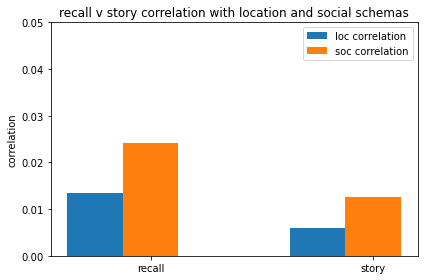

In [17]:
# loc correlation
loc_plot = np.zeros((2,1))

# soc correlation
soc_plot = np.zeros((2,1))

# assign values
# correlation with loc
loc_plot[0] = recall_loc_avg
loc_plot[1] = story_loc_avg


#proportion that are soc
soc_plot[0] = recall_soc_avg
soc_plot[1] = story_soc_avg

loc_plot = loc_plot.ravel()
soc_plot = soc_plot.ravel()

#labels
labels = ['recall', 'story']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x, loc_plot, width, label='loc correlation')
rects2 = ax.bar(x + width, soc_plot, width, label='soc correlation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('correlation')
ax.set_title('recall v story correlation with location and social schemas')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim([0, .05])
fig.tight_layout()

plt.show()




# Separate recalls by priming group

In [18]:
# separate words into priming groups

prime_separated = {}

for key in all_wvs:
    n = all_wvs[key].shape[0]
    no_primed = np.zeros((0,300))
    loc_primed = np.zeros((0,300))
    soc_primed = np.zeros((0,300))
    for i in range(0, n):
        this_priming = all_priming[key][i]
        if this_priming == 0:
            no_primed = np.vstack((no_primed, all_wvs[key][i]))
        elif this_priming == 1:
            loc_primed = np.vstack((loc_primed, all_wvs[key][i]))
        else:
            soc_primed = np.vstack((soc_primed, all_wvs[key][i]))
    prime_separated[key] = {0:no_primed, 1:loc_primed, 2:soc_primed}

# Loc correlation with recalls

In [19]:
### A. Correlate each word with the LOC WV

#structure loc_cors
loc_cors = {}
for key in prime_separated:
    loc_cors[key] = {}

for key in prime_separated:
    for priming in prime_separated[key]:
        n = prime_separated[key][priming].shape[0]
        this_loc_cors = np.zeros((n,1))
        loc = key%10
        this_loc = templates[loc].reshape(templates[loc].shape[0], -1)
        for i in range(0, n):
            this_wv = prime_separated[key][priming][i].reshape(prime_separated[key][priming][i].shape[0], -1)
            this_correl = np.corrcoef(this_loc.T, this_wv.T)
            this_loc_cors[i] = this_correl[0,1]
        loc_cors[key][priming] = np.ravel(this_loc_cors)
    
#avg loc cors

loc_concat_np = np.zeros((0,1))
loc_concat_loc = np.zeros((0,1))
loc_concat_soc = np.zeros((0,1))

lcs = [loc_concat_np, loc_concat_loc, loc_concat_soc]

for i in range(0,3):
    for key in loc_cors:
        this_loc = loc_cors[key][i].reshape(loc_cors[key][i].shape[0], -1)
        lcs[i] = np.vstack((lcs[i], this_loc))

recall_loc_avg_np = np.nanmean(lcs[0])
recall_loc_avg_loc = np.nanmean(lcs[1])
recall_loc_avg_soc = np.nanmean(lcs[2])

# Soc correlation with recalls

In [20]:
### A. Correlate each word with the SOC WV

#structure loc_cors
soc_cors = {}
for key in prime_separated:
    soc_cors[key] = {}

for key in prime_separated:
    for priming in prime_separated[key]:
        n = prime_separated[key][priming].shape[0]
        this_soc_cors = np.zeros((n,1))
        soc = round(int(key)/10)*10
        this_soc = templates[soc].reshape(templates[soc].shape[0], -1)
        for i in range(0, n):
            this_wv = prime_separated[key][priming][i].reshape(prime_separated[key][priming][i].shape[0], -1)
            this_correl = np.corrcoef(this_soc.T, this_wv.T)
            this_soc_cors[i] = this_correl[0,1]
        soc_cors[key][priming] = np.ravel(this_soc_cors)
    
#avg loc cors

soc_concat_np = np.zeros((0,1))
soc_concat_loc = np.zeros((0,1))
soc_concat_soc = np.zeros((0,1))

scs = [soc_concat_np, soc_concat_loc, soc_concat_soc]

for i in range(0,3):
    for key in soc_cors:
        this_soc = soc_cors[key][i].reshape(soc_cors[key][i].shape[0], -1)
        scs[i] = np.vstack((scs[i], this_soc))

recall_soc_avg_np = np.nanmean(scs[0])
recall_soc_avg_loc = np.nanmean(scs[1])
recall_soc_avg_soc = np.nanmean(scs[2])

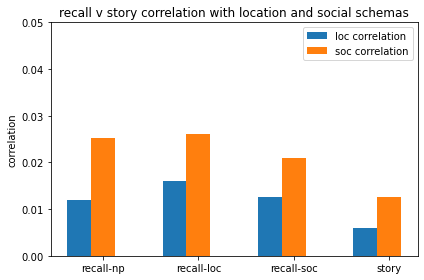

In [21]:
# loc correlation
loc_plot = np.zeros((4,1))

# soc correlation
soc_plot = np.zeros((4,1))

# assign values
# correlation with loc
loc_plot[0] = recall_loc_avg_np
loc_plot[1] = recall_loc_avg_loc
loc_plot[2] = recall_loc_avg_soc
loc_plot[3] = story_loc_avg


#proportion that are soc
soc_plot[0] = recall_soc_avg_np
soc_plot[1] = recall_soc_avg_loc
soc_plot[2] = recall_soc_avg_soc
soc_plot[3] = story_soc_avg

loc_plot = loc_plot.ravel()
soc_plot = soc_plot.ravel()

#labels
labels = ['recall-np', 'recall-loc', 'recall-soc', 'story']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x, loc_plot, width, label='loc correlation')
rects2 = ax.bar(x + width, soc_plot, width, label='soc correlation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('correlation')
ax.set_title('recall v story correlation with location and social schemas')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim([0, .05])
fig.tight_layout()

plt.show()


